<a href="https://colab.research.google.com/github/pranav-nambiar/movie-recommender-system/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [70]:
import os

In [71]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q Findspark
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

In [72]:
os.environ["JAVA_HOME"]

'/usr/lib/jvm/java-8-openjdk-amd64'

In [73]:
os.environ["SPARK_HOME"]

'/content/spark-2.4.7-bin-hadoop2.7'

As we can see above, Java and Spark are configured properly and so we can now go ahead and start loading data.

In [74]:
import findspark
findspark.init()

In [75]:
#Start Apache Spark session and context
import pyspark
from pyspark.sql import SQLContext

In [76]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('BigDataProject').getOrCreate()

# Reading the data

In [77]:
from google.colab import drive
drive.mount('/content/drive');

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
!ls "drive/My Drive/Big_Data_Movie_Recommender"

Data  Results


In [79]:
DATA_PATH = "drive/My Drive/Big_Data_Movie_Recommender/Data"
RESULTS_PATH = "drive/My Drive/Big_Data_Movie_Recommender/Results"

In [80]:
ratings = spark.read.option("header", "true").csv(DATA_PATH+"/ratings.csv")
ratings.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    296|   5.0|1147880044|
|     1|    306|   3.5|1147868817|
|     1|    307|   5.0|1147868828|
|     1|    665|   5.0|1147878820|
|     1|    899|   3.5|1147868510|
+------+-------+------+----------+
only showing top 5 rows



In [81]:
movies = spark.read.option("header", "true").csv(DATA_PATH+"/movies.csv")
movies.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



# The most popular Movies

In [82]:
from pyspark.sql.functions import *

most_popular = ratings\
.groupBy("movieId")\
.agg(count("userId"))\
.withColumnRenamed("count(userId)", "num_ratings")\
.sort(desc("num_ratings"))

In [83]:
#To show the top 10 most popular movies.
most_popular.show(10)

+-------+-----------+
|movieId|num_ratings|
+-------+-----------+
|    356|      81491|
|    318|      81482|
|    296|      79672|
|    593|      74127|
|   2571|      72674|
|    260|      68717|
|    480|      64144|
|    527|      60411|
|    110|      59184|
|   2959|      58773|
+-------+-----------+
only showing top 10 rows



We can see only the movieId and the number of ratings. The name of the movie is contained in the movies.csv file. So we have to use that to display the name of the movie here.

In [84]:
#Showing the top 15 movies.
most_popular_movies = most_popular.join(movies, ["movieId"])
most_popular_movies = most_popular_movies \
.sort(desc("num_ratings"))
most_popular_movies.show(15)

+-------+-----------+--------------------+--------------------+
|movieId|num_ratings|               title|              genres|
+-------+-----------+--------------------+--------------------+
|    356|      81491| Forrest Gump (1994)|Comedy|Drama|Roma...|
|    318|      81482|Shawshank Redempt...|         Crime|Drama|
|    296|      79672| Pulp Fiction (1994)|Comedy|Crime|Dram...|
|    593|      74127|Silence of the La...|Crime|Horror|Thri...|
|   2571|      72674|  Matrix, The (1999)|Action|Sci-Fi|Thr...|
|    260|      68717|Star Wars: Episod...|Action|Adventure|...|
|    480|      64144|Jurassic Park (1993)|Action|Adventure|...|
|    527|      60411|Schindler's List ...|           Drama|War|
|    110|      59184|   Braveheart (1995)|    Action|Drama|War|
|   2959|      58773|   Fight Club (1999)|Action|Crime|Dram...|
|    589|      57379|Terminator 2: Jud...|       Action|Sci-Fi|
|   1196|      57361|Star Wars: Episod...|Action|Adventure|...|
|      1|      57309|    Toy Story (1995

As we can see, most of the movies shown above are really popular and well known.

# Top Rated Movies

If we just sort based on the ratings, we can get movies which have 5 starts but have very few ratings. See the example below.

In [85]:
top_rated = ratings\
.groupBy("movieId")\
.agg(avg(col("rating")))\
.withColumnRenamed("avg(rating)", "avg_rating")\
.sort(desc("avg_rating"))

In [86]:
top_rated_movies = top_rated.join(movies, ['movieId']).sort(desc("avg_rating"))
top_rated_movies.show(10)

+-------+----------+--------------------+--------------------+
|movieId|avg_rating|               title|              genres|
+-------+----------+--------------------+--------------------+
| 175095|       5.0|The Exhibitionist...|               Drama|
| 136914|       5.0|         RISE (2014)|Crime|Drama|Thriller|
| 139289|       5.0|The Shattering (2...|              Horror|
| 136782|       5.0|The Girl is in Tr...|            Thriller|
| 159050|       5.0|The Pilot's Wife ...|  (no genres listed)|
| 169338|       5.0|Brad Williams: Da...|              Comedy|
| 194280|       5.0|        Panic (1982)|       Horror|Sci-Fi|
| 200296|       5.0|The Control Group...|              Horror|
| 187951|       5.0|Father of Lights ...|         Documentary|
| 159904|       5.0|Living on Love (1...|      Comedy|Romance|
+-------+----------+--------------------+--------------------+
only showing top 10 rows



We can see that these movies are have very high average rating but are not really well known. This is because they could have very few 5 star ratings and still be shown here. To avoid this, we will have to consider top rated movies with also a good number of ratings.

In [87]:
top_rated = ratings\
.groupBy("movieId")\
.agg(count("userId"), avg(col("rating")))\
.withColumnRenamed("count(userId)", "num_ratings")\
.withColumnRenamed("avg(rating)", "avg_rating")


top_rated_movies = top_rated.join(movies, ['movieId']).sort(desc("avg_rating"), desc("num_ratings"))
top_rated_movies.show(50)

+-------+-----------+----------+--------------------+--------------------+
|movieId|num_ratings|avg_rating|               title|              genres|
+-------+-----------+----------+--------------------+--------------------+
| 165787|          3|       5.0|Lonesome Dove Chu...|             Western|
| 118268|          3|       5.0|Borrowed Time (2012)|               Drama|
| 179731|          3|       5.0|Sound of Christma...|               Drama|
| 148298|          3|       5.0|       Awaken (2013)|Drama|Romance|Sci-Fi|
| 201821|          2|       5.0| Civilisation (1969)|  (no genres listed)|
| 159797|          2|       5.0|La muerte de Jaim...|         Documentary|
| 184903|          2|       5.0|     Joy Road (2011)|         Crime|Drama|
| 133297|          2|       5.0|Genius on Hold (2...|  (no genres listed)|
| 168020|          2|       5.0|Christmas Angel (...|Comedy|Drama|Romance|
| 183357|          2|       5.0|    Bidder 70 (2013)|  (no genres listed)|
| 169232|          2|    

Like you can see above, there are only 3 ratings for the first top rated movie. So we have to set a threshold like around 500 at the least.

In [88]:
top_rated_movies.where("num_ratings > 500").show(20)

+-------+-----------+------------------+--------------------+--------------------+
|movieId|num_ratings|        avg_rating|               title|              genres|
+-------+-----------+------------------+--------------------+--------------------+
| 171011|       1124| 4.483096085409253|Planet Earth II (...|         Documentary|
| 159817|       1747| 4.464796794504865| Planet Earth (2006)|         Documentary|
|    318|      81482| 4.413576004516335|Shawshank Redempt...|         Crime|Drama|
| 170705|       1356| 4.398598820058997|Band of Brothers ...|    Action|Drama|War|
|    858|      52498| 4.324336165187245|Godfather, The (1...|         Crime|Drama|
| 179135|        659| 4.289833080424886|Blue Planet II (2...|         Documentary|
|     50|      55366| 4.284353213163313|Usual Suspects, T...|Crime|Mystery|Thr...|
|   1221|      34188|4.2617585117585115|Godfather: Part I...|         Crime|Drama|
| 163809|        546| 4.258241758241758|Over the Garden W...|Adventure|Animati...|
|   

Now we can see that these movies have quite a few ratings are are well known. We can tweak the number of ratings to see movies which have more ratings.

# Most Polarizing Movies

Polarizing movies are those which people either hate or love. Some people love it while a few others hate it.  
We can find these by looking for movies which have the highest standard deviation in the ratings. Standard Deviation is a measure of how much the data varies from the mean and so we hope this is a good measure for that.

In [89]:
ratings_stddev = ratings\
.groupBy("movieId")\
.agg(count("userId").alias("num_ratings"), 
     avg(col("rating")).alias("avg_rating"),
     stddev(col("rating")).alias("std_rating")
    )\
.where("num_ratings > 500")

marmite_movies = ratings_stddev.join(movies, ['movieId'])
marmite_movies.sort(desc("std_rating")).show(15)

+-------+-----------+------------------+------------------+--------------------+--------------------+
|movieId|num_ratings|        avg_rating|        std_rating|               title|              genres|
+-------+-----------+------------------+------------------+--------------------+--------------------+
|  74754|        670| 2.403731343283582|1.6649650528666515|    Room, The (2003)|Comedy|Drama|Romance|
|  62912|        611|2.5106382978723403|1.4888552380190527|High School Music...|             Musical|
|  98203|       1569|2.5242192479286167|1.4560043846864676|Twilight Saga: Br...|Adventure|Drama|F...|
|  27899|        616|2.7767857142857144| 1.445519028350731|What the #$*! Do ...|Comedy|Documentar...|
|  91104|       1896|2.3285864978902953| 1.442346851125679|Twilight Saga: Br...|Adventure|Drama|F...|
|   1924|       2210| 2.613348416289593| 1.417228312413465|Plan 9 from Outer...|       Horror|Sci-Fi|
|  78772|       2857|2.3773188659432973| 1.405303363298029|Twilight Saga: Ec...|Fa

We can see that these movies are pretty popular and are actually in that category. A simple Google search for these movie ratings shows mixed results. Some really like it and some hate it.

# Visualizations

In [24]:
#Installing koalas. Needed for some visualizations.
!pip install koalas > /dev/null

In [25]:
!pip install seaborn > /dev/null

In [43]:
#Importing packages needed for visualizations
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import random
from pprint import pprint
from matplotlib.lines import Line2D
import databricks.koalas as ks

#Set-up
plt.style.use('ggplot')

### Number of Ratings Per User

In [50]:
ks.set_option('compute.default_index_type', 'sequence')
ks.set_option('compute.ops_on_diff_frames', True)
dfRatingsKdf = ratings.to_koalas()

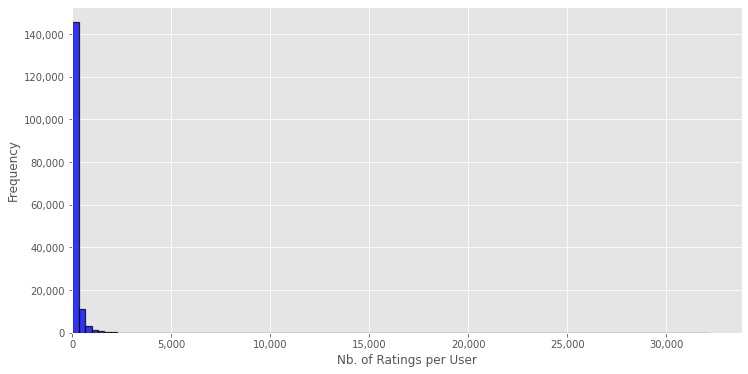

In [51]:
f, ax = plt.subplots(figsize=(12,6))
userRatingGroup = dfRatingsKdf.groupby("userId")['rating'].count()
userRatingGroup.hist(bins=100, color='blue', edgecolor='black',
                     linewidth=1.25, alpha=0.78, ax=ax)
ax.set_xlabel('Nb. of Ratings per User')
ax.set_xlim(0.0)
ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.show()

We can see from the above graph that most number of users i.e. greater than 1,40,000 of them have rated very few movies.

### Number of Ratings Per Movie

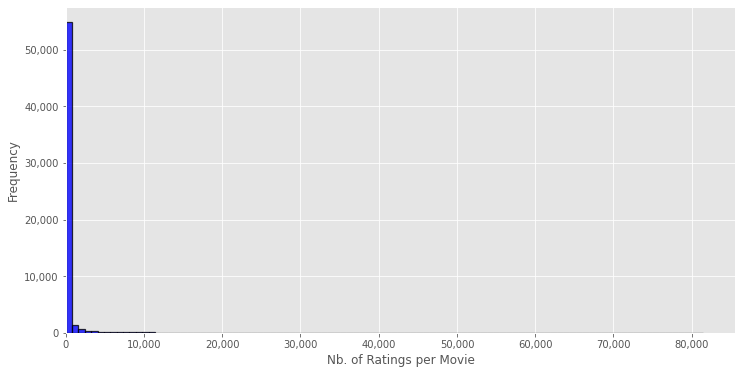

In [52]:
f, ax = plt.subplots(figsize=(12,6))
movieRatingGroup = dfRatingsKdf.groupby("movieId")['rating'].count()
movieRatingGroup.hist(bins=100, color='blue', edgecolor='black',
                      linewidth=1.25, alpha=0.78, ax=ax)
ax.set_xlabel('Nb. of Ratings per Movie')
ax.set_xlim(0.0)
ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.show()

This is the similar to the above case.

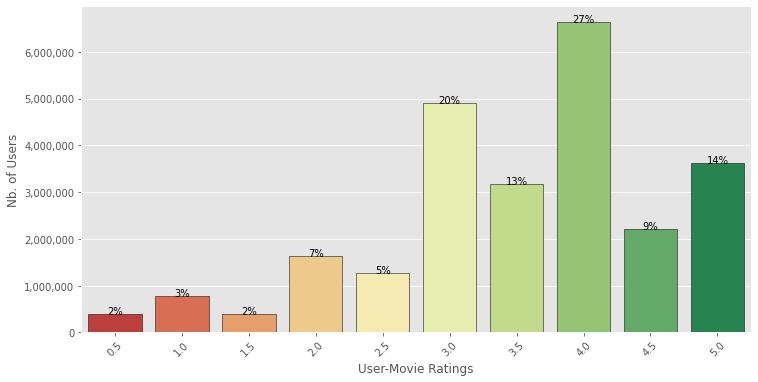

In [53]:
movieRatingDistGroup = dfRatingsKdf['rating'].value_counts() \
                                             .sort_index() \
                                             .reset_index() \
                                             .to_pandas()

# Create Matplotlib Figure
fig, ax = plt.subplots(figsize=(12,6))

# Main Figure: Seaborn Barplot
sns.barplot(data=movieRatingDistGroup, x='index', y='rating',
            palette='RdYlGn', edgecolor="black", ax=ax)

# Set Xaxis and Yaxis
ax.set_xlabel("User-Movie Ratings")
ax.set_ylabel('Nb. of Users')
ax.xaxis.set_tick_params(rotation=45)

# Thousand separator on Yaxis labels
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

# Add percentage text on top of each bar
total = float(movieRatingDistGroup['rating'].sum())
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+350,
            '{0:.0%}'.format(height/total),
            ha="center") 

# Display plot
plt.show()

In [54]:
type(dfRatingsKdf),type(ratings)

(databricks.koalas.frame.DataFrame, pyspark.sql.dataframe.DataFrame)

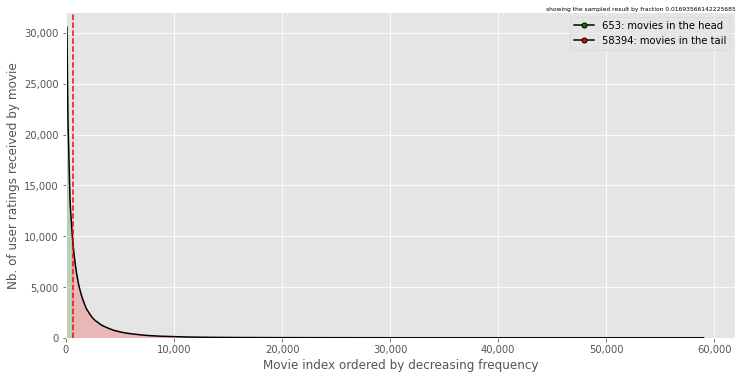

In [55]:
f, ax = plt.subplots(figsize=(12,6))

# Calculate Cumulative Volumes
item_id_column = "movieId"
volume_df = dfRatingsKdf[item_id_column].value_counts().reset_index()
volume_df.columns = [item_id_column, "volume"]
volume_df[item_id_column] = volume_df[item_id_column].astype(str)
volume_df['cumulative_volume'] = volume_df['volume'].cumsum()
volume_df['percent_of_total_volume'] = \
    volume_df['cumulative_volume']/volume_df['volume'].sum()

# Main
temp = volume_df['volume']
temp.plot(kind='line', ax=ax, color='black')

ax.set_xlim(-15)
ax.set_ylim(0.0)
ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set_xlabel('Movie index ordered by decreasing frequency')
ax.set_ylabel('Nb. of user ratings received by movie')

# Plot vertical line at the tail location
percentage = 0.5
head = volume_df[volume_df.percent_of_total_volume <= percentage]
tail = volume_df[volume_df.percent_of_total_volume > percentage]
items_in_head = len(head)
items_in_tail = len(tail)

plt.axvline(x=items_in_head, color="red",  linestyle='--')

# Legend
legend_elements = [Line2D([0], [0], marker='o', color='black',
                          label=str(items_in_head)+': movies in the head',
                          markerfacecolor='green', markersize=5),
                    
                    Line2D([0], [0], marker='o', color='black',
                          label=str(items_in_tail)+': movies in the tail',
                          markerfacecolor='red', markersize=5)]
ax.legend(handles=legend_elements, loc=1)

# Fill area under plot
head = head.append(tail.head(1))
x1 = head.index.to_pandas().to_numpy() 
y1 = head['volume'].to_pandas()        
x2 = tail.index.to_pandas().to_numpy() 
y2 = tail['volume'].to_pandas()        
ax.fill_between(x1, y1, color="green", alpha=0.2)
ax.fill_between(x2, y2,  color="red", alpha=0.2)

plt.show()

Only 653 movies lie within the top 0.5% of the movies, taking number of ratings into consideration. The remaining form the 'long tail'. Chris Anderson, in his book, *The Long Tail: Why the Future of Business is Selling Less of More*, argues that products in low demand or that have a low sales volume can collectively build a better market share than their relatively few but popular rivals, provided the product distribution is large enough. In this regard, an online marketspace alleviates competition for shelf space, allowing immeasurable number of products to be sold. He notes that Amazon, Apple and Yahoo are some of the businesses applying this strategy.

A good recommendation engine should exploit this strategy and recommend more items from the long tail to the users.